In [1]:
import sys
sys.path.append('../..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm
import random as rnd
from tools.GA.CropGeneticAlgorithm import CropGeneticAlgorithm

In [2]:
path = "../datasets/Images/Chicken disease"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

../datasets/Images/Chicken disease/Coccidiosis
../datasets/Images/Chicken disease/Healthy
../datasets/Images/Chicken disease/New Castle Disease
../datasets/Images/Chicken disease/Salmonella


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(4555, 224, 224, 3) Y_train:(4555,) X_test:(1953, 224, 224, 3) Y_test:(1953,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(folder_path), activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

7/7 [==============================] - 0s 17ms/step - loss: 5.4934 - accuracy: 0.3744
0.48739142417907716


In [10]:
filterGeneticAlgorithm=FilterGeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [11]:
best_filter= filterGeneticAlgorithm.run(generation_limit=3, population_size=24)

--------------------------------------------------------------------------------
15/15 [==============================] - 0s 19ms/step - loss: 0.7655 - accuracy: 0.7231
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.6559866070747375
--------------------------------------------------------------------------------
15/15 [==============================] - 0s 19ms/step - loss: 3.5807 - accuracy: 0.3121
filter [55, 86, 39, 211, 6, 224, 83, 157, 66, 57, 22, 3, 5, 33, 359, 2] fit: 0.3119698345661163
--------------------------------------------------------------------------------
15/15 [==============================] - 0s 19ms/step - loss: 1.0514 - accuracy: 0.4835
filter [9, 108, 70, 193, 80, 209, 21, 111, 66, 148, 3, 5, 4, 33, 357, 0] fit: 0.5510357707738877
--------------------------------------------------------------------------------
15/15 [==============================] - 0s 19ms/step - loss: 0.8461 - accuracy: 0.7121
filter [58, 100, 27, 149, 77, 125, 170, 1

In [12]:
print(f"\nbest filter :{best_filter.filter} fit: {best_filter.fit}")


best filter :[4, 130, 55, 148, 18, 214, 121, 110, 106, 104, 10, 0, 5, 34, 438, 0] fit: 0.7771722674369812


In [13]:
filtered_X_train=np.array(filterGeneticAlgorithm.get_newData(X_train,filter=best_filter.filter))
filtered_X_test=np.array(filterGeneticAlgorithm.get_newData(X_test,filter=best_filter.filter))


print(f"X_train:{filtered_X_train.shape} Y_train:{Y_train.shape} X_test:{filtered_X_test.shape} Y_test:{Y_test.shape}")

X_train:(4555, 224, 224, 3) Y_train:(4555,) X_test:(1953, 224, 224, 3) Y_test:(1953,)


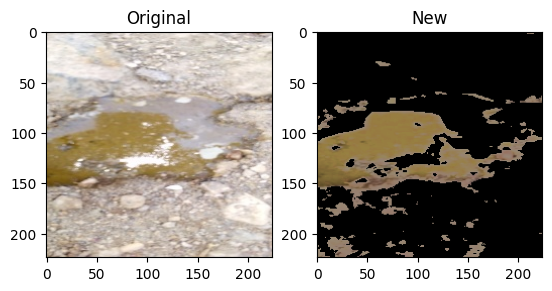

In [57]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(filtered_X_test[index])
ax2.set_title('New')

plt.show()

In [21]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

7/7 [==============================] - 0s 18ms/step - loss: 0.9401 - accuracy: 0.6923
0.7270617604255676
